In [2]:
!pip install wfdb neurokit2
# numpy, scipy, matplotlib are usually pre-installed

import wfdb
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import neurokit2 as nk
import os # For navigating paths
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.5/696.5 kB 25.0 MB/s eta 0:00:00


In [3]:

TARGET_FS = 200  # Hz
# FILTER_LOWCUT = 0.5  # Hz 
# FILTER_HIGHCUT = 40.0  # Hz 
# FILTER_ORDER = 4

SEGMENT_SAMPLES = 1000 # Final segment length for CNN (e.g., 1000 samples @ 200Hz = 5 seconds)
R2R_P2T_PIECE_SAMPLES = 200 # Length of each piece before combining 5
NUM_PIECES_COMBINE = 5

NORM_MIN = -512
NORM_MAX = 512


In [4]:

# Base path for the dataset in Kaggle
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/'

# Function to plot signals for inspection (same as before)
def plot_signal(signal, fs, title="Signal", x_label="Samples", y_label="Amplitude"):
    # If fs is None, it means the x-axis is already in samples
    if fs is not None:
        time_axis = np.arange(len(signal)) / fs
        x_input = time_axis
        if x_label == "Samples": # Default, but if fs provided, use time
             x_label_to_use = "Time (s)"
        else:
            x_label_to_use = x_label
    else:
        x_input = np.arange(len(signal))
        x_label_to_use = x_label

    plt.figure(figsize=(12, 4))
    plt.plot(x_input, signal)
    plt.title(title)
    plt.xlabel(x_label_to_use)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

# Load Dataset

In [5]:


def load_ecg_id_record(person_id_str, record_num_str, use_filtered=True):
    record_path_without_ext = os.path.join(BASE_DATA_PATH, person_id_str, record_num_str)
    print(f"Attempting to load record from: {record_path_without_ext}")
    try:
        # wfdb.rdsamp is returning a tuple: (signal_array, metadata_dict)
        returned_data = wfdb.rdsamp(record_path_without_ext)
        
        print(f"Type of object returned by wfdb.rdsamp: {type(returned_data)}")

        if not isinstance(returned_data, tuple) or len(returned_data) != 2:
            print("wfdb.rdsamp did not return the expected (signal, metadata) tuple.")
            return None, None

        signal_array = returned_data[0]  # The first element is the signal data
        metadata_dict = returned_data[1] # The second element is the metadata dictionary

        if use_filtered:
            # Ensure there are at least 2 columns if asking for column 1
            if signal_array.ndim == 1 or signal_array.shape[1] < 2 :
                print(f"Error: Requested filtered signal (column 1) but signal array has shape {signal_array.shape}")
                return None, None
            signal = signal_array[:, 1] 
            signal_type = "Filtered"
        else:
            signal = signal_array[:, 0] 
            signal_type = "Raw"
            
        fs = metadata_dict['fs'] # Get 'fs' from the metadata dictionary
        
        print(f"Loaded: {person_id_str}/{record_num_str} ({signal_type}), Original Fs: {fs} Hz, Signal length: {len(signal)}")
        return signal, fs # Return the selected signal column and fs
        
    except FileNotFoundError:
        print(f"Error: File not found for record {record_path_without_ext}")
        return None, None
    except Exception as e:
        print(f"General error loading record {record_path_without_ext}: {e}")
        import traceback
        traceback.print_exc()
        return None, None



Attempting to load record from: /kaggle/input/ecg-id/ecg-id-database-1.0.0/Person_01/rec_1
Type of object returned by wfdb.rdsamp: <class 'tuple'>
Loaded: Person_01/rec_1 (Filtered), Original Fs: 500 Hz, Signal length: 10000
Successfully loaded signal. Shape: (10000,), FS: 500


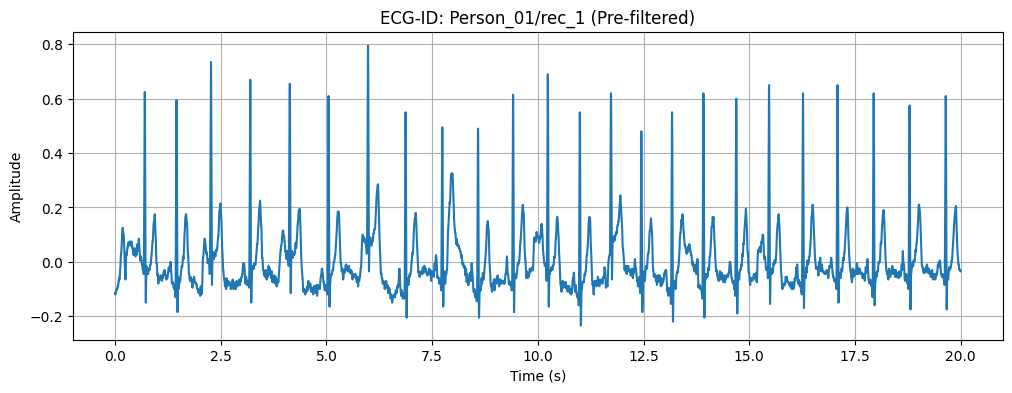

Final original_fs value: 500


In [6]:

person_id = 'Person_01'
record_num = 'rec_1'
ecg_signal, original_fs = load_ecg_id_record(person_id, record_num, use_filtered=True)

if ecg_signal is not None:
    print(f"Successfully loaded signal. Shape: {ecg_signal.shape}, FS: {original_fs}")
    plot_signal(ecg_signal, original_fs, title=f"ECG-ID: {person_id}/{record_num} (Pre-filtered)")
else:
    print("Failed to load signal (as determined by load_ecg_id_record return).")

print(f"Final original_fs value: {original_fs}")

In [7]:


TARGET_FS = 200  # Hz
# FILTER_LOWCUT = 0.5  # Hz 
# FILTER_HIGHCUT = 40.0  # Hz 
# FILTER_ORDER = 4

SEGMENT_SAMPLES = 1000 
R2R_P2T_PIECE_SAMPLES = 200 
NUM_PIECES_COMBINE = 5 

NORM_MIN = -512
NORM_MAX = 512

import scipy.signal as sig # For resampling
import neurokit2 as nk # For peak detection and delineation
# numpy as np, matplotlib.pyplot as plt, os should already be imported


def resample_signal(signal, original_fs, target_fs):
    if original_fs == target_fs:
        print("Signal already at target frequency.")
        return signal
    # Ensure signal is not empty or too short for resampling
    if signal is None or len(signal) == 0:
        print("Cannot resample an empty signal.")
        return np.array([]) # Return empty array
    num_samples_target = int(len(signal) * target_fs / original_fs)
    if num_samples_target < 1 : # Need at least 1 sample
        print(f"Target samples for resampling is {num_samples_target}, too small. Original len: {len(signal)}")
        return np.array([])
    resampled_signal = sig.resample(signal, num_samples_target)
    print(f"Resampled signal from {original_fs} Hz to {target_fs} Hz. New length: {len(resampled_signal)}")
    return resampled_signal

def segment_npd(signal, segment_len_samples=SEGMENT_SAMPLES, num_segments_to_extract=10):
    segments = []
    signal_len = len(signal)
    if signal_len < segment_len_samples:
        print(f"NPD: Signal too short ({signal_len} samples) for segment length ({segment_len_samples} samples).")
        return segments
    for _ in range(num_segments_to_extract):
        start_idx = np.random.randint(0, signal_len - segment_len_samples + 1)
        segment = signal[start_idx : start_idx + segment_len_samples]
        segments.append(segment)
    print(f"NPD: Extracted {len(segments)} segments of length {segment_len_samples}")
    return segments

def segment_r2r(signal, fs, piece_target_samples=R2R_P2T_PIECE_SAMPLES, num_pieces_to_combine=NUM_PIECES_COMBINE):
    segments = []
    if signal is None or len(signal) < fs : # Basic check for signal validity
        print("R2R: Invalid or too short input signal.")
        return segments
    try:
        _, rpeaks_info = nk.ecg_peaks(signal, sampling_rate=fs, method='neurokit')
        rpeak_indices = rpeaks_info['ECG_R_Peaks']
    except Exception as e:
        print(f"R2R: R-peak detection failed: {e}")
        return segments
    if len(rpeak_indices) < num_pieces_to_combine + 1:
        print(f"R2R: Not enough R-peaks ({len(rpeak_indices)}) for segmentation requiring {num_pieces_to_combine+1} peaks.")
        return segments
    ecg_pieces = []
    for i in range(len(rpeak_indices) - 1):
        start_r, end_r = rpeak_indices[i], rpeak_indices[i+1]
        piece = signal[start_r:end_r]
        min_beat_len, max_beat_len = int(0.3 * fs), int(1.5 * fs)
        if not (min_beat_len <= len(piece) <= max_beat_len and len(piece) > 1) : continue
        resampled_piece = sig.resample(piece, piece_target_samples)
        ecg_pieces.append(resampled_piece)
    if len(ecg_pieces) < num_pieces_to_combine:
        print(f"R2R: Not enough valid pieces ({len(ecg_pieces)}) after filtering/resampling for {num_pieces_to_combine}-piece combination.")
        return segments
    for i in range(len(ecg_pieces) - num_pieces_to_combine + 1):
        combined_segment = np.concatenate(ecg_pieces[i : i + num_pieces_to_combine])
        segments.append(combined_segment)
    print(f"R2R: Extracted {len(segments)} segments of length {len(segments[0]) if segments else 0}")
    return segments

def segment_p2t(signal, fs, piece_target_samples=R2R_P2T_PIECE_SAMPLES, num_pieces_to_combine=NUM_PIECES_COMBINE):
    segments = []
    if signal is None or len(signal) < fs: # Basic check
        print("P2T: Invalid or too short input signal.")
        return segments
    try:
        _, rpeaks_info = nk.ecg_peaks(signal, sampling_rate=fs, method='neurokit')
        rpeak_indices = rpeaks_info['ECG_R_Peaks']
        if len(rpeak_indices) < 1:
            print("P2T: No R-peaks found for delineation.")
            return segments
        _, waves = nk.ecg_delineate(signal, rpeak_indices, sampling_rate=fs, method='dwt')
    except Exception as e:
        print(f"P2T: ECG delineation failed: {e}")
        return segments
    ecg_pieces = []
    num_beats = len(rpeak_indices) # Max possible beats to check based on R-peaks
    # Ensure wave arrays are long enough; NeuroKit might return shorter arrays if delineation fails for later beats
    p_peaks_arr = waves.get('ECG_P_Peaks', [])
    t_peaks_arr = waves.get('ECG_T_Peaks', [])

    for i in range(num_beats):
        p_peak_idx = p_peaks_arr[i] if i < len(p_peaks_arr) else np.nan
        t_peak_idx = t_peaks_arr[i] if i < len(t_peaks_arr) else np.nan
        if not (np.isnan(p_peak_idx) or np.isnan(t_peak_idx) or t_peak_idx <= p_peak_idx):
            p_peak_idx, t_peak_idx = int(p_peak_idx), int(t_peak_idx)
            piece = signal[p_peak_idx : t_peak_idx]
            min_pt_len, max_pt_len = int(0.1 * fs), int(0.8 * fs)
            if not (min_pt_len <= len(piece) <= max_pt_len and len(piece) > 1): continue
            resampled_piece = sig.resample(piece, piece_target_samples)
            ecg_pieces.append(resampled_piece)
    if len(ecg_pieces) < num_pieces_to_combine:
        print(f"P2T: Not enough valid pieces ({len(ecg_pieces)}) after filtering/resampling for {num_pieces_to_combine}-piece combination.")
        return segments
    for i in range(len(ecg_pieces) - num_pieces_to_combine + 1):
        combined_segment = np.concatenate(ecg_pieces[i : i + num_pieces_to_combine])
        segments.append(combined_segment)
    print(f"P2T: Extracted {len(segments)} segments of length {len(segments[0]) if segments else 0}")
    return segments

def normalize_segment(segment, min_val=NORM_MIN, max_val=NORM_MAX):
    seg_min, seg_max = np.min(segment), np.max(segment)
    if seg_max == seg_min: return np.full_like(segment, (min_val + max_val) / 2.0)
    normalized = (segment - seg_min) / (seg_max - seg_min)
    normalized = normalized * (max_val - min_val) + min_val
    return normalized


--- Starting Resampling ---
Resampled signal from 500 Hz to 200 Hz. New length: 4000


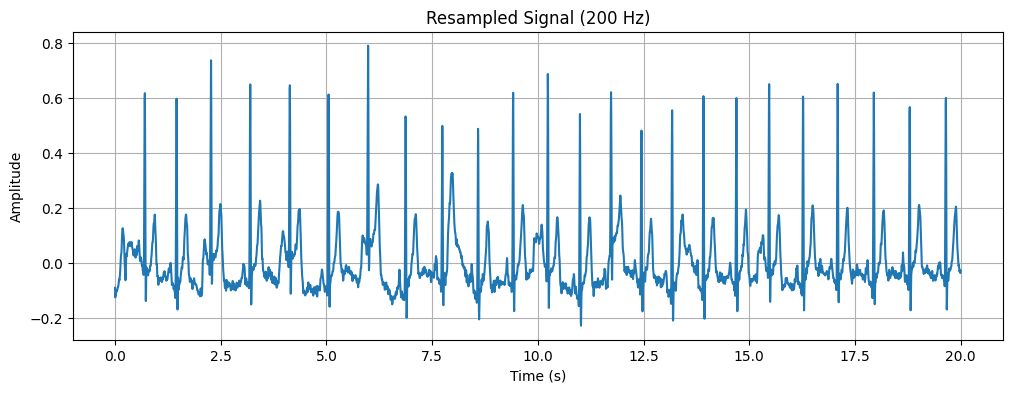


--- Starting NPD Segmentation ---
NPD: Extracted 3 segments of length 1000


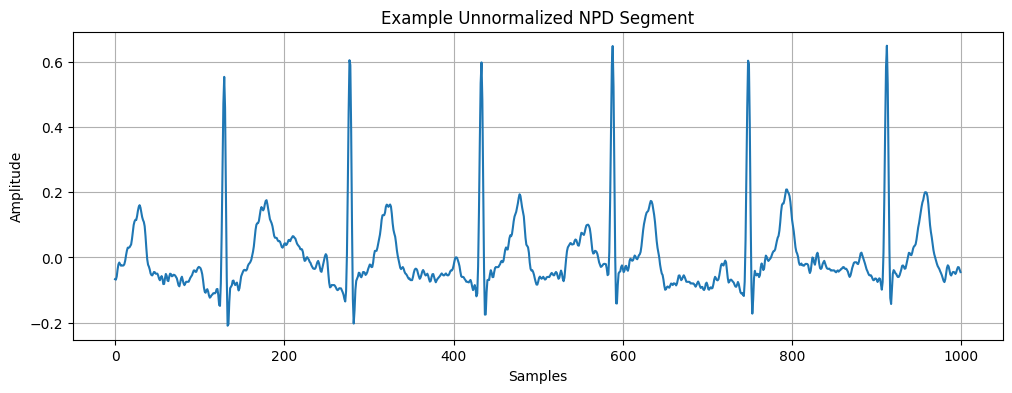


--- Starting R2R Segmentation ---
R2R: Extracted 19 segments of length 1000


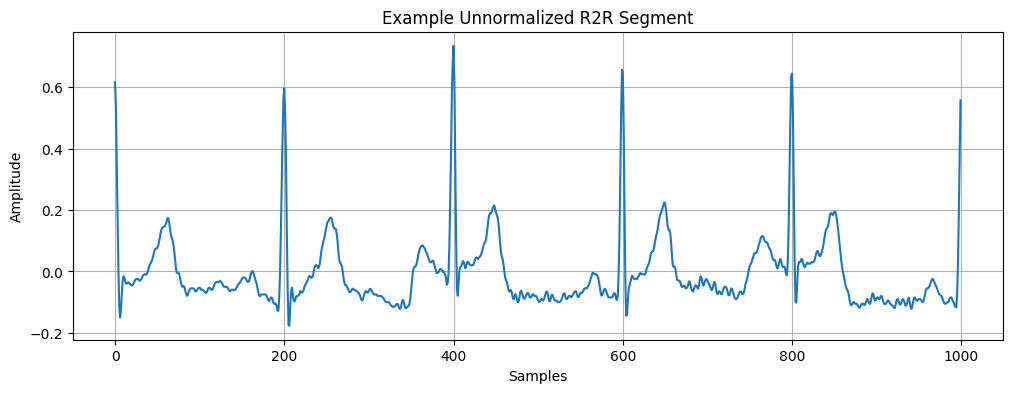


--- Starting P2T Segmentation ---
P2T: Extracted 20 segments of length 1000


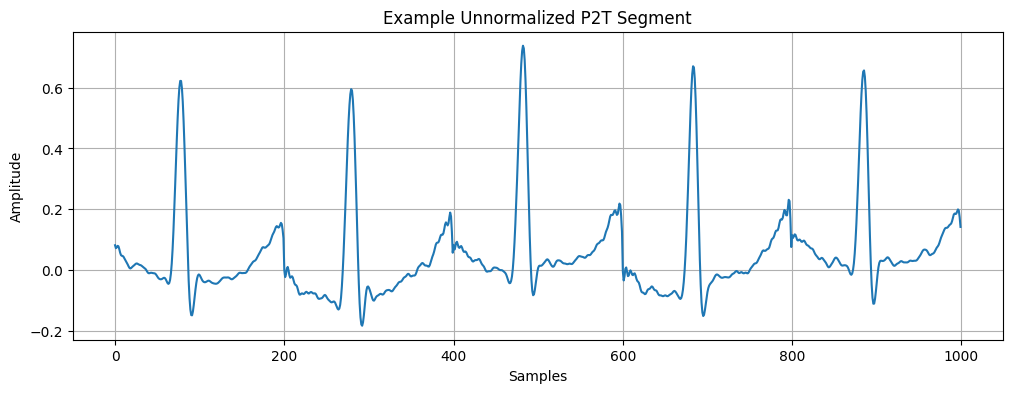


--- Normalizing Segments ---


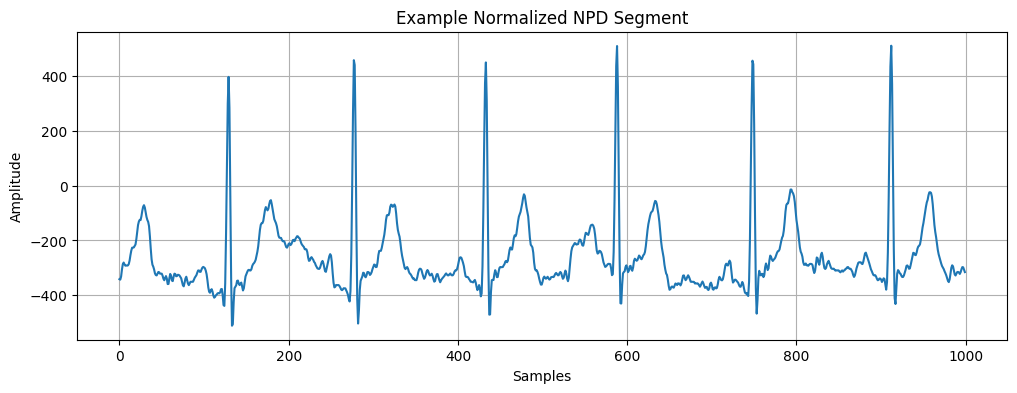

NPD - Min/Max of first normalized segment: -512.00, 512.00


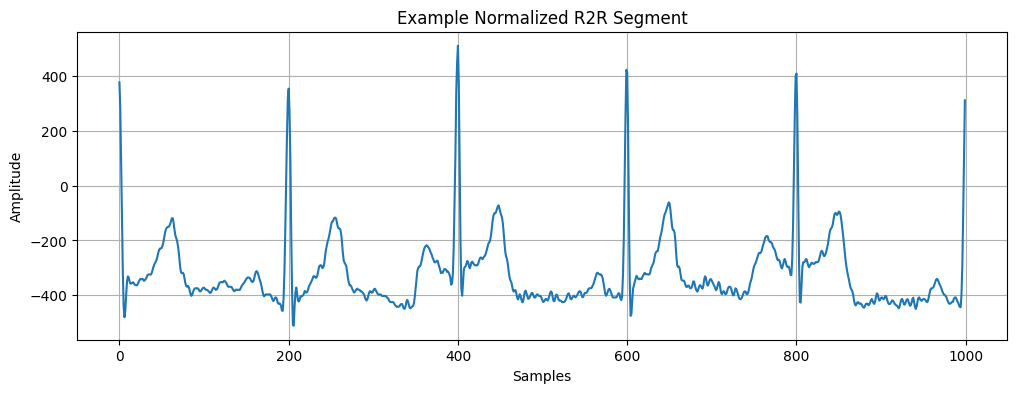

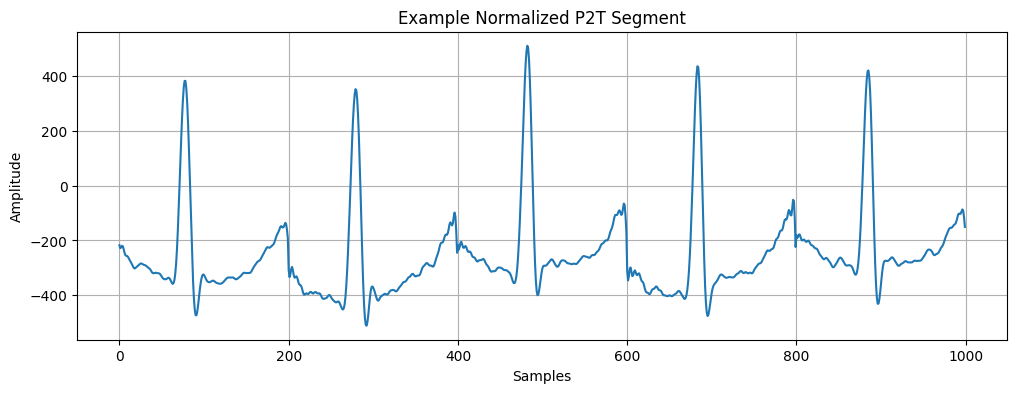


--- Preprocessing Summary for One Record ---
NPD: Generated 3 segments.
   Length of NPD segments: 1000
R2R: Generated 19 segments.
   Length of R2R segments: 1000
P2T: Generated 20 segments.
   Length of P2T segments: 1000


In [8]:
# --- Step 1: Resample the loaded signal ---
if ecg_signal is not None and original_fs is not None:
    print(f"\n--- Starting Resampling ---")
    processed_signal = resample_signal(ecg_signal, original_fs, TARGET_FS)
    current_fs = TARGET_FS # This is the sampling rate for subsequent processing

    if processed_signal.size > 0: # Check if resampling was successful
        plot_signal(processed_signal, current_fs, title=f"Resampled Signal ({current_fs} Hz)")

        # --- Step 2: Apply Segmentation Methods ---
        print(f"\n--- Starting NPD Segmentation ---")
        # For a 20s signal (4000 samples at 200Hz), we can extract a few NPD segments
        # SEGMENT_SAMPLES is 1000.
        npd_segments_unnormalized = segment_npd(processed_signal,
                                                segment_len_samples=SEGMENT_SAMPLES,
                                                num_segments_to_extract=3) # Extract 3 example segments
        if npd_segments_unnormalized:
            plot_signal(npd_segments_unnormalized[0], fs=None, title="Example Unnormalized NPD Segment", x_label="Samples")

        print(f"\n--- Starting R2R Segmentation ---")
        # R2R_P2T_PIECE_SAMPLES = 200, NUM_PIECES_COMBINE = 5 => 1000 sample segments
        r2r_segments_unnormalized = segment_r2r(processed_signal, current_fs,
                                                piece_target_samples=R2R_P2T_PIECE_SAMPLES,
                                                num_pieces_to_combine=NUM_PIECES_COMBINE)
        if r2r_segments_unnormalized:
            plot_signal(r2r_segments_unnormalized[0], fs=None, title="Example Unnormalized R2R Segment", x_label="Samples")

        print(f"\n--- Starting P2T Segmentation ---")
        p2t_segments_unnormalized = segment_p2t(processed_signal, current_fs,
                                                piece_target_samples=R2R_P2T_PIECE_SAMPLES,
                                                num_pieces_to_combine=NUM_PIECES_COMBINE)
        if p2t_segments_unnormalized:
            plot_signal(p2t_segments_unnormalized[0], fs=None, title="Example Unnormalized P2T Segment", x_label="Samples")

        # --- Step 3: Normalize the Generated Segments ---
        print(f"\n--- Normalizing Segments ---")
        normalized_npd_segments = [normalize_segment(s, NORM_MIN, NORM_MAX) for s in npd_segments_unnormalized]
        normalized_r2r_segments = [normalize_segment(s, NORM_MIN, NORM_MAX) for s in r2r_segments_unnormalized]
        normalized_p2t_segments = [normalize_segment(s, NORM_MIN, NORM_MAX) for s in p2t_segments_unnormalized]

        if normalized_npd_segments:
            plot_signal(normalized_npd_segments[0], fs=None, title="Example Normalized NPD Segment", x_label="Samples")
            print(f"NPD - Min/Max of first normalized segment: {np.min(normalized_npd_segments[0]):.2f}, {np.max(normalized_npd_segments[0]):.2f}")
        if normalized_r2r_segments:
            plot_signal(normalized_r2r_segments[0], fs=None, title="Example Normalized R2R Segment", x_label="Samples")
        if normalized_p2t_segments:
            plot_signal(normalized_p2t_segments[0], fs=None, title="Example Normalized P2T Segment", x_label="Samples")

        print("\n--- Preprocessing Summary for One Record ---")
        print(f"NPD: Generated {len(normalized_npd_segments)} segments.")
        if normalized_npd_segments: print(f"   Length of NPD segments: {len(normalized_npd_segments[0])}")

        print(f"R2R: Generated {len(normalized_r2r_segments)} segments.")
        if normalized_r2r_segments: print(f"   Length of R2R segments: {len(normalized_r2r_segments[0])}")

        print(f"P2T: Generated {len(normalized_p2t_segments)} segments.")
        if normalized_p2t_segments: print(f"   Length of P2T segments: {len(normalized_p2t_segments[0])}")
    else:
        print("Resampling failed or produced an empty signal. Cannot proceed with segmentation.")
else:
    print("ecg_signal or original_fs is None. Cannot proceed. Please re-run the loading cell.")

# WIDE PREPROCESSING

In [10]:
import wfdb
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import neurokit2 as nk # Still needed if you were to switch to R2R/P2T
import os
import random # For NPD if you want different random segments each time

# --- Configuration Parameters (ensure these are defined) ---
BASE_DATA_PATH = '/kaggle/input/ecg-id/ecg-id-database-1.0.0/'
TARGET_FS = 200  # Hz
SEGMENT_SAMPLES = 1000 # Final segment length for CNN
R2R_P2T_PIECE_SAMPLES = 200
NUM_PIECES_COMBINE = 5
NORM_MIN = -512
NORM_MAX = 512

# --- Helper Function Definitions (copy from previous, ensure they are in scope) ---
# plot_signal, load_ecg_id_record, resample_signal,
# segment_npd, segment_r2r, segment_p2t, normalize_segment

# (Make sure all helper functions from the previous complete preprocessing script are defined here)
def load_ecg_id_record(person_id_str, record_num_str, use_filtered=True):
    record_path_without_ext = os.path.join(BASE_DATA_PATH, person_id_str, record_num_str)
    # print(f"Attempting to load record from: {record_path_without_ext}") # Can be verbose
    try:
        returned_data = wfdb.rdsamp(record_path_without_ext)
        if not isinstance(returned_data, tuple) or len(returned_data) != 2:
            print(f"wfdb.rdsamp did not return expected tuple for {record_path_without_ext}.")
            return None, None
        signal_array, metadata_dict = returned_data[0], returned_data[1]
        if use_filtered:
            if signal_array.ndim == 1 or signal_array.shape[1] < 2: return None, None
            signal = signal_array[:, 1]
        else:
            signal = signal_array[:, 0]
        fs = metadata_dict['fs']
        return signal, fs
    except Exception as e:
        # print(f"Error loading {record_path_without_ext}: {e}") # Can be verbose
        return None, None

def resample_signal(signal, original_fs, target_fs):
    if original_fs == target_fs: return signal
    if signal is None or len(signal) == 0: return np.array([])
    num_samples_target = int(len(signal) * target_fs / original_fs)
    if num_samples_target < 1 : return np.array([])
    return sig.resample(signal, num_samples_target)

def segment_npd(signal, segment_len_samples=SEGMENT_SAMPLES, num_segments_to_extract=10):
    segments = []
    signal_len = len(signal)
    if signal_len < segment_len_samples: return segments
    # Ensure num_segments_to_extract is not more than possible unique segments if signal is short
    max_possible_segments = signal_len - segment_len_samples + 1
    actual_segments_to_extract = min(num_segments_to_extract, max_possible_segments)
    if actual_segments_to_extract <=0: return segments

    # If you want the *same* random segments for reproducibility when running again on the same signal:
    # np.random.seed(42) # Or some other fixed seed, set once outside if globally desired
    
    for _ in range(actual_segments_to_extract):
        start_idx = np.random.randint(0, signal_len - segment_len_samples + 1)
        segment = signal[start_idx : start_idx + segment_len_samples]
        segments.append(segment)
    return segments

def normalize_segment(segment, min_val=NORM_MIN, max_val=NORM_MAX):
    seg_min, seg_max = np.min(segment), np.max(segment)
    if seg_max == seg_min: return np.full_like(segment, (min_val + max_val) / 2.0)
    normalized = (segment - seg_min) / (seg_max - seg_min)
    return normalized * (max_val - min_val) + min_val


In [11]:
# UPDATED CELL FOR 30 DATA

In [12]:

# --- Data Storage ---
all_processed_segments = [] 
source_ids_list = [] # Storing source_ids separately now for clarity

# --- MODIFIED LIMITS for More Data ---
MAX_PERSONS_TO_PROCESS = 70 # Process first 30 persons, or try more if time allows
# MAX_RECORDS_PER_PERSON = 5 # Let's try to process ALL records for selected persons
                           # We will control this within the loop by not having a max_records limit
SEGMENTS_PER_RECORD_NPD = 15 # Extract 15 NPD segments from each record

print("--- Starting Dataset-Wide Preprocessing (Expanded Run) ---")

person_folders = sorted([d for d in os.listdir(BASE_DATA_PATH) if os.path.isdir(os.path.join(BASE_DATA_PATH, d)) and d.startswith('Person_')])

persons_processed_count = 0
for person_folder_name in person_folders:
    if persons_processed_count >= MAX_PERSONS_TO_PROCESS:
        print(f"Reached MAX_PERSONS_TO_PROCESS limit ({MAX_PERSONS_TO_PROCESS}). Stopping person loop.")
        break
    
    print(f"\nProcessing {person_folder_name} ({persons_processed_count+1}/{MAX_PERSONS_TO_PROCESS})...")
    person_path = os.path.join(BASE_DATA_PATH, person_folder_name)
    
    record_base_names = sorted(list(set([f.split('.')[0] for f in os.listdir(person_path) if f.startswith('rec_') and f.endswith('.dat')])))
    
    # No MAX_RECORDS_PER_PERSON limit here, process all records for the selected person
    for rec_idx, rec_base_name in enumerate(record_base_names):
        print(f"  Loading record: {rec_base_name} ({rec_idx+1}/{len(record_base_names)} for this person)...")
        ecg_signal, original_fs = load_ecg_id_record(person_folder_name, rec_base_name, use_filtered=True)

        if ecg_signal is not None and original_fs is not None:
            resampled_ecg = resample_signal(ecg_signal, original_fs, TARGET_FS)

            if resampled_ecg.size > SEGMENT_SAMPLES: # Ensure signal is long enough for at least one segment
                unnormalized_segments = segment_npd(resampled_ecg, 
                                                    segment_len_samples=SEGMENT_SAMPLES, 
                                                    num_segments_to_extract=SEGMENTS_PER_RECORD_NPD)
                
                current_segment_count = 0
                for un_seg in unnormalized_segments:
                    norm_seg = normalize_segment(un_seg, NORM_MIN, NORM_MAX)
                    source_id = (person_folder_name, rec_base_name) 
                    all_processed_segments.append(norm_seg) # Store segment
                    source_ids_list.append(source_id)     # Store corresponding source_id
                    current_segment_count += 1
                print(f"    Stored {current_segment_count} segments from {person_folder_name}/{rec_base_name}")
            else:
                print(f"    Skipping {rec_base_name} due to resampling failure or signal too short after resampling ({resampled_ecg.size} samples).")
        else:
            print(f"    Skipping {rec_base_name} due to loading failure.")
        
    persons_processed_count += 1

print(f"\n--- Finished Preprocessing ---")
print(f"Total processed segments stored: {len(all_processed_segments)}")


--- Starting Dataset-Wide Preprocessing (Expanded Run) ---

Processing Person_01 (1/70)...
  Loading record: rec_1 (1/20 for this person)...
    Stored 15 segments from Person_01/rec_1
  Loading record: rec_10 (2/20 for this person)...
    Stored 15 segments from Person_01/rec_10
  Loading record: rec_11 (3/20 for this person)...
    Stored 15 segments from Person_01/rec_11
  Loading record: rec_12 (4/20 for this person)...
    Stored 15 segments from Person_01/rec_12
  Loading record: rec_13 (5/20 for this person)...
    Stored 15 segments from Person_01/rec_13
  Loading record: rec_14 (6/20 for this person)...
    Stored 15 segments from Person_01/rec_14
  Loading record: rec_15 (7/20 for this person)...
    Stored 15 segments from Person_01/rec_15
  Loading record: rec_16 (8/20 for this person)...
    Stored 15 segments from Person_01/rec_16
  Loading record: rec_17 (9/20 for this person)...
    Stored 15 segments from Person_01/rec_17
  Loading record: rec_18 (10/20 for this person

In [13]:

if all_processed_segments:
    # Convert to NumPy array for easier handling by deep learning frameworks
    X_data = np.array(all_processed_segments)
    # source_ids_list is already a list of tuples
    
    print(f"Shape of X_data (segments): {X_data.shape}")
    # X_data will be (num_total_segments, SEGMENT_SAMPLES)
    
    # For TensorFlow/Keras CNNs expecting a channel dimension:
    if X_data.ndim == 2: # Ensure it's (num_segments, segment_length) before expanding
        X_data_cnn = np.expand_dims(X_data, axis=-1)
        print(f"Shape of X_data_cnn (for CNN input): {X_data_cnn.shape}")
    else:
        print(f"Error: X_data has unexpected shape {X_data.shape}. Cannot expand dims.")
        X_data_cnn = np.array([]) # Prevent further errors
else:
    print("No segments were processed.")
    X_data_cnn = np.array([]) 
    source_ids_list = [] # Keep consistent

# --- IMPORTANT: Update the global variable name for source_ids if you used a different one in the Triplet Generator ---
# In the Triplet Generator, I used 'source_ids' as the input list of source identifiers.
# Let's ensure this is consistent.
source_ids = source_ids_list # Make sure the variable name matches what the Triplet Generator expects

Shape of X_data (segments): (3855, 1000)
Shape of X_data_cnn (for CNN input): (3855, 1000, 1)


In [14]:
X_data

array([[-390.46233767, -402.254013  , -410.95860759, ..., -217.34489442,
        -209.43229848, -207.66653249],
       [-387.37600207, -392.53902686, -394.86201559, ..., -267.43316751,
        -264.85657697, -258.8151728 ],
       [-319.87526675, -324.28929296, -322.58345775, ..., -346.82046707,
        -351.6297799 , -351.16771369],
       ...,
       [-188.46744074, -260.78362625, -299.7627756 , ..., -310.36022183,
        -317.34750829, -332.3502113 ],
       [  58.77228112,   54.81158551,   81.97932388, ..., -363.02191715,
        -319.56360309, -269.27362028],
       [-365.87256436, -341.0563311 , -338.5725499 , ..., -337.20863611,
        -363.26752159, -381.22311881]])

# CNN ENCODER

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Activation


def build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034):
    """
    Builds the 1D CNN encoder model more closely following Figure 4,
    with a final dense layer to achieve the text's embedding_dim.
    """
    input_layer = Input(shape=input_shape, name="encoder_input")
    
    # Block 1 (Conv1, Pool1) - Filters: 16, Kernel: 3
    x = Conv1D(filters=16, kernel_size=3, strides=1, padding='same', name="conv1")(input_layer)
    x = BatchNormalization(name="bn1")(x)
    x = Activation('relu', name="relu1")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool1")(x) # 1000 -> 500

    # Block 2 (Conv2, Pool2) - Filters: 32, Kernel: 5
    x = Conv1D(filters=32, kernel_size=5, strides=1, padding='same', name="conv2")(x)
    x = BatchNormalization(name="bn2")(x)
    x = Activation('relu', name="relu2")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool2")(x) # 500 -> 250

    # Block 3 (Conv3, Pool3) - Filters: 64, Kernel: 3
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same', name="conv3")(x)
    x = BatchNormalization(name="bn3")(x)
    x = Activation('relu', name="relu3")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool3")(x) # 250 -> 125

    # Block 4 (Conv4, Pool4) - Filters: 128, Kernel: 5
    x = Conv1D(filters=128, kernel_size=5, strides=1, padding='same', name="conv4")(x)
    x = BatchNormalization(name="bn4")(x)
    x = Activation('relu', name="relu4")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool4")(x) # 125 -> 62 (if padding='same' handled it, or 62 if floor)

    # Block 5 (Conv5, Pool5) - Filters: 256, Kernel: 3
    x = Conv1D(filters=256, kernel_size=3, strides=1, padding='same', name="conv5")(x)
    x = BatchNormalization(name="bn5")(x)
    x = Activation('relu', name="relu5")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool5")(x) # 62 -> 31

    # Block 6 (Conv6, Pool6) - Filters: 256, Kernel: 5
    x = Conv1D(filters=256, kernel_size=5, strides=1, padding='same', name="conv6")(x)
    x = BatchNormalization(name="bn6")(x)
    x = Activation('relu', name="relu6")(x)
    x = MaxPooling1D(pool_size=2, strides=2, name="pool6")(x) 
    # Flatten
    x = Flatten(name="flatten")(x)
    output_features = Dense(embedding_dim, activation=None, name="embedding_output")(x) # No activation for embeddings
    
    encoder_model = Model(inputs=input_layer, outputs=output_features, name="cnn_encoder_fig4")
    return encoder_model

# --- Build and summarize the model ---
SEGMENT_SAMPLES = 1000 

cnn_encoder_updated = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
cnn_encoder_updated.summary()


Model: "cnn_encoder_fig4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 1000, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 1000, 16)            │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1 (Activation)                   │ (None, 1000, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling1D)                 │ (None, 500, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 500, 32)             │           2,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 500, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2 (Activation)                   │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling1D)                 │ (None, 250, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv1D)                       │ (None, 250, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3 (BatchNormalization)             │ (None, 250, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3 (Activation)                   │ (None, 250, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling1D)                 │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv1D)                       │ (None, 125, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn4 (BatchNormalization)             │ (None, 125, 128)            │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu4 (Activation)                   │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling1D)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5 (Conv1D)                       │ (None, 62, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn5 (BatchNormalization)             │ (None, 62, 256)             │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu5 (Activation)                   │ (None, 62, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling1D)                 │ (None, 31, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)

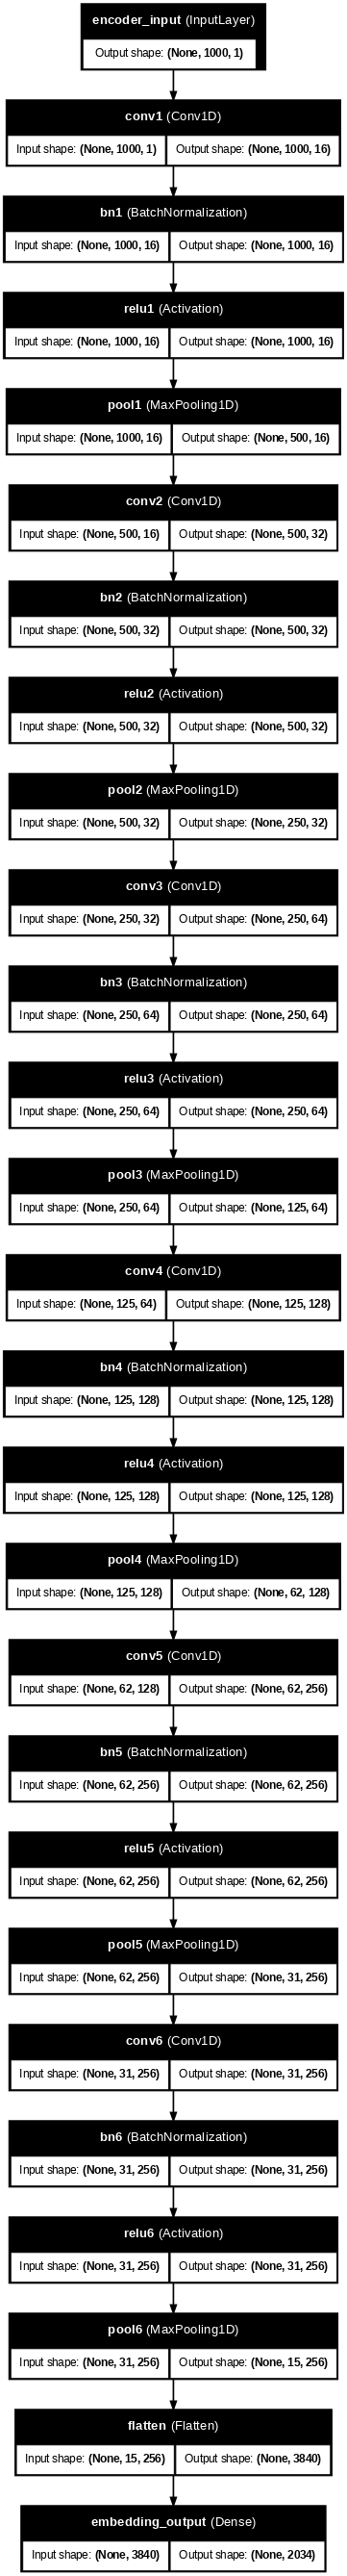

In [98]:

#Plot model ( pydot and graphviz )
tf.keras.utils.plot_model(cnn_encoder_updated, show_shapes=True, show_layer_names=True, dpi=60)

# triplet_generator

In [99]:

# These variables should be populated from your successful preprocessing cell:
# X_data_cnn: NumPy array of shape (1920, 1000, 1)
# source_ids: List of 1920 tuples, e.g., [('Person_01', 'rec_1'), ('Person_01', 'rec_1'), ...]

print(f"Using X_data_cnn with shape: {X_data_cnn.shape}")
print(f"Using source_ids list with length: {len(source_ids)}")

# Group segments by their source_id for easier positive pair sampling
segments_by_source = {}
for i, src_id in enumerate(source_ids): # Use the globally updated 'source_ids'
    # src_id is a tuple like ('Person_01', 'rec_1')
    # Make sure src_id is hashable (tuples are)
    if src_id not in segments_by_source:
        segments_by_source[src_id] = []
    segments_by_source[src_id].append(i) # Store indices of segments

# Remove sources with only one segment, as they can't form positive pairs for triplets
sources_for_triplets = {src: idx_list for src, idx_list in segments_by_source.items() if len(idx_list) >= 2}
list_of_source_keys = list(sources_for_triplets.keys())

print(f"\nNumber of unique source_ids (Person, Record pairs): {len(segments_by_source)}")
print(f"Number of sources with >= 2 segments (usable for triplets): {len(sources_for_triplets)}")

if len(sources_for_triplets) < 2: # Need at least two distinct (Person,Record) pairs that can provide an Anchor/Positive
    print("CRITICAL: Not enough diverse sources to form triplets effectively. ")
    print("           Need at least 2 different (Person,Record) pairs, each with >=2 segments.")
    print("           Training may not be meaningful. Consider processing even more data from more persons.")
    train_generator = None
elif not list_of_source_keys: # Should be covered by above, but good to be safe
     print("CRITICAL: list_of_source_keys is empty. Cannot proceed with triplet generation.")
     train_generator = None
else:
    # Define the triplet_generator function (copy from previous response if not in a cell above)
    def triplet_generator(X_data_input, source_ids_map_input, list_of_sources_input, batch_size_input):
        while True:
            anchors_idx, positives_idx, negatives_idx = [], [], []
            for _ in range(batch_size_input):
                if not list_of_sources_input: break # Should not happen if initial checks pass

                anchor_source_id = random.choice(list_of_sources_input)
                # Ensure the chosen anchor_source_id actually has >= 2 segments in the map
                if len(source_ids_map_input.get(anchor_source_id, [])) < 2:
                    # This source became invalid somehow (should not happen with current logic but defensive)
                    # Or, if list_of_sources_input was not filtered properly.
                    # Let's try to pick another one or skip this iteration.
                    continue 
                anchor_idx, positive_idx = random.sample(source_ids_map_input[anchor_source_id], 2)

                negative_source_id = random.choice(list_of_sources_input)
                max_retries, retry_count = 10, 0
                while negative_source_id == anchor_source_id and len(list_of_sources_input) > 1 and retry_count < max_retries:
                    negative_source_id = random.choice(list_of_sources_input)
                    retry_count += 1
                
                # Ensure the chosen negative_source_id is valid and has segments
                if not source_ids_map_input.get(negative_source_id, []):
                    continue # Skip if no segments for chosen negative source

                negative_idx = random.choice(source_ids_map_input[negative_source_id])

                anchors_idx.append(anchor_idx)
                positives_idx.append(positive_idx)
                negatives_idx.append(negative_idx)
            
            if not anchors_idx: continue # If loop above didn't add any, try batch again

            batch_anchors = X_data_input[anchors_idx]
            batch_positives = X_data_input[positives_idx]
            batch_negatives = X_data_input[negatives_idx]
            yield (batch_anchors, batch_positives, batch_negatives), np.zeros((len(anchors_idx), 1))

    BATCH_SIZE =16 # Can try a slightly larger batch size now, e.g., 16 or 32
                    # Total data = 1920. 1920/16 = 120 batches if all data used once.
    train_generator = triplet_generator(X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE)
    
    # Test the generator for one batch
    print(f"\nTriplet generator created with BATCH_SIZE = {BATCH_SIZE}")
    try:
        [sample_anchors, sample_positives, sample_negatives], _ = next(train_generator)
        print("Successfully generated one batch of triplets:")
        print("  Sample Anchor shape:", sample_anchors.shape)
        print("  Sample Positive shape:", sample_positives.shape)
        print("  Sample Negative shape:", sample_negatives.shape)
    except StopIteration:
        print("ERROR: Triplet generator did not yield any data. Check data diversity and generator logic.")
        train_generator = None # Mark as unusable
    except Exception as e:
        print(f"ERROR testing triplet generator: {e}")
        train_generator = None



Using X_data_cnn with shape: (3855, 1000, 1)
Using source_ids list with length: 3855

Number of unique source_ids (Person, Record pairs): 257
Number of sources with >= 2 segments (usable for triplets): 257

Triplet generator created with BATCH_SIZE = 16
Successfully generated one batch of triplets:
  Sample Anchor shape: (16, 1000, 1)
  Sample Positive shape: (16, 1000, 1)
  Sample Negative shape: (16, 1000, 1)


# Define PCC Similarity, Triplet Network, and Loss Function

In [100]:
import tensorflow as tf # Make sure tf is imported
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda, Layer # Add Layer for completeness if needed elsewhere
from tensorflow.keras.models import Model

ALPHA_MARGIN = 0.8

def pcc_similarity(tensors):
    emb1, emb2 = tensors
    mean1 = K.mean(emb1, axis=-1, keepdims=True)
    mean2 = K.mean(emb2, axis=-1, keepdims=True)
    centered1 = emb1 - mean1
    centered2 = emb2 - mean2
    covariance = K.sum(centered1 * centered2, axis=-1)
    stddev1 = K.sqrt(K.sum(K.square(centered1), axis=-1))
    stddev2 = K.sqrt(K.sum(K.square(centered2), axis=-1))
    pcc = covariance / (stddev1 * stddev2 + K.epsilon())
    return pcc

# --- Assume cnn_encoder_updated is defined from the previous cell ---
# --- Assume SEGMENT_SAMPLES is defined ---
SEGMENT_SAMPLES = 1000 # ensure it's defined

input_anchor = Input(shape=(SEGMENT_SAMPLES, 1), name="anchor_input")
input_positive = Input(shape=(SEGMENT_SAMPLES, 1), name="positive_input")
input_negative = Input(shape=(SEGMENT_SAMPLES, 1), name="negative_input")

embedding_anchor = cnn_encoder_updated(input_anchor)
embedding_positive = cnn_encoder_updated(input_positive)
embedding_negative = cnn_encoder_updated(input_negative)

pcc_ap = Lambda(pcc_similarity, name="pcc_anchor_positive")([embedding_anchor, embedding_positive])
pcc_an = Lambda(pcc_similarity, name="pcc_anchor_negative")([embedding_anchor, embedding_negative])

# --- MODIFICATION HERE ---
# Wrap tf.stack in a Lambda layer
def stack_pccs_fn(inputs): # Define a helper function for the Lambda layer
    pcc1, pcc2 = inputs
    return tf.stack([pcc1, pcc2], axis=1)

stacked_pccs = Lambda(stack_pccs_fn, name="stacked_pcc_similarities")([pcc_ap, pcc_an])
# --- END MODIFICATION ---


triplet_network = Model(inputs=[input_anchor, input_positive, input_negative], 
                        outputs=stacked_pccs, 
                        name="triplet_network")

triplet_network.summary() # Good to check the summary after this change

def triplet_loss_pcc(y_true, y_pred_stacked_pccs):
    pcc_ap = y_pred_stacked_pccs[:, 0]
    pcc_an = y_pred_stacked_pccs[:, 1]
    loss = K.maximum(0.0, ALPHA_MARGIN - (pcc_ap - pcc_an))
    return K.mean(loss)

print("\nPCC similarity, Triplet Network, and Loss function defined (with tf.stack wrapped in Lambda).")

Model: "triplet_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer) │ (None, 1000, 1)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positive_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ negative_input            │ (None, 1000, 1)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cnn_encoder_fig4          │ (None, 2034)           │      8,292,050 │ anchor_input[0][0],    │
│ (Functional)              │                        │                │ positive_input[0][0],  │
│                           │                        │                │ negative_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pcc_anchor_positive       │ (None)                 │              0 │ cnn_encoder_fig4[0][0… │
│ (Lambda)                  │                        │                │ cnn_encoder_fig4[1][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pcc_anchor_negative       │ (None)                 │              0 │ cnn_encoder_fig4[0][0… │
│ (Lambda)                  │                        │                │ cnn_encoder_fig4[2][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stacked_pcc_similarities  │ (None, 2)              │              0 │ pcc_anchor_positive[0… │
│ (Lambda)                  │                        │                │ pcc_anchor_negative[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,292,050 (31.63 MB)

 Trainable params: 8,290,546 (31.63 MB)

 Non-trainable params: 1,504 (5.88 KB)


PCC similarity, Triplet Network, and Loss function defined (with tf.stack wrapped in Lambda).


# Compile and Train

Triplet network compiled (or already compiled).

Starting training with BATCH_SIZE=16, EPOCHS=50, STEPS_PER_EPOCH=120
Using pre-existing Python train_generator instance to create tf.data.Dataset (less common).
tf.data.Dataset created successfully from generator using a callable.
Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.3685
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2860
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2726
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2330
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2193
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1917
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2471
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2042
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1955
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1715
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/

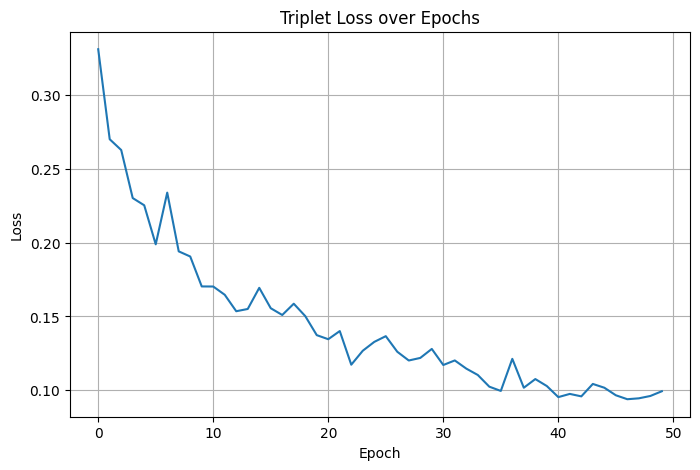

In [101]:
import tensorflow as tf # Ensure tf is imported
import numpy as np    # Ensure np is imported
import matplotlib.pyplot as plt # For plotting


# Optimizer (ensure it's defined, e.g., from previous cell)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005) 
triplet_network.compile(optimizer=optimizer, loss=triplet_loss_pcc) # This should have been done

print("Triplet network compiled (or already compiled).")

# --- Training ---
EPOCHS = 50
if X_data_cnn.size > 0 and len(sources_for_triplets) > 1 :
    STEPS_PER_EPOCH = max(1, int(len(X_data_cnn) / BATCH_SIZE / 2)) 
    if STEPS_PER_EPOCH < 10:
        STEPS_PER_EPOCH = min(10, int(len(X_data_cnn) / BATCH_SIZE) if BATCH_SIZE > 0 else 10)
    
    print(f"\nStarting training with BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}, STEPS_PER_EPOCH={STEPS_PER_EPOCH}")

    if 'SEGMENT_SAMPLES' not in locals():
        SEGMENT_SAMPLES = 1000 # Define if somehow missing

    output_sig = (
        ( # This tuple corresponds to the first element yielded by the generator: [A, P, N]
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32), # Anchor
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32), # Positive
            tf.TensorSpec(shape=(None, SEGMENT_SAMPLES, 1), dtype=tf.float32)  # Negative
        ), 
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32) # This corresponds to the dummy labels
    )

    if 'train_generator' not in locals() or train_generator is None:
        # Attempt to recreate the Python generator instance if it was not created or set to None
        print("Python train_generator instance not found or was None, attempting to recreate...")
        if len(sources_for_triplets) >= 1 and \
           (len(sources_for_triplets) > 1 or \
            (list_of_source_keys and len(sources_for_triplets.get(list_of_source_keys[0], [])) >= BATCH_SIZE*2 ) ):
        
            py_train_generator_fn = lambda: triplet_generator(
                X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE
            )
            tf_train_dataset = tf.data.Dataset.from_generator(
                py_train_generator_fn, # Pass the function that creates the generator
                output_signature=output_sig
            )
            print("tf.data.Dataset created successfully from generator.")
        else:
            print("Still not enough data/diversity to create a robust Python generator for tf.data.Dataset.")
            tf_train_dataset = None
    else:
        print("Using pre-existing Python train_generator instance to create tf.data.Dataset (less common).")

        py_train_generator_fn = lambda: triplet_generator( # Define the callable
            X_data_cnn, sources_for_triplets, list_of_source_keys, BATCH_SIZE
        )
        tf_train_dataset = tf.data.Dataset.from_generator(
            py_train_generator_fn,
            output_signature=output_sig
        )
        print("tf.data.Dataset created successfully from generator using a callable.")


    if tf_train_dataset:
        # Optional: Prefetch for performance
        tf_train_dataset = tf_train_dataset.prefetch(tf.data.AUTOTUNE)

        history = triplet_network.fit(
            tf_train_dataset, # Pass the tf.data.Dataset object
            epochs=EPOCHS,
            steps_per_epoch=STEPS_PER_EPOCH, # STEPS_PER_EPOCH should still be defined
            verbose=1
        )
        print("\nTraining finished.")
        
        if 'loss' in history.history:
            plt.figure(figsize=(8,5))
            plt.plot(history.history['loss'])
            plt.title('Triplet Loss over Epochs')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.grid(True)
            plt.show()
        else:
            print("No 'loss' key in history.history. Cannot plot loss.")
    else:
        print("tf.data.Dataset could not be created. Cannot start training.")
        
else:
    print("\nNot enough processed data or source diversity to start training the triplet network.")
    # ... (rest of the error message as before) ...

# Saving for future


In [102]:

cnn_encoder_updated.save_weights('trained_cnn_encoder_weights.weights.h5') 
# save the whole model if you prefer, though for inference we just need the encoder
cnn_encoder_updated.save('trained_cnn_encoder_model.keras')
print("Trained CNN encoder weights saved.")

Trained CNN encoder weights saved.


In [103]:

# fresh_encoder = build_cnn_encoder_fig4(input_shape=(SEGMENT_SAMPLES, 1), embedding_dim=2034)
# fresh_encoder.load_weights('trained_cnn_encoder_weights.weights.h5')

# Week 4 > Authentication

In [104]:
X_data_cnn.shape

(3855, 1000, 1)

In [105]:
len(source_ids)

3855

In [106]:
source_ids[100]

('Person_01', 'rec_15')

# Splitting Data for Authentication Evaluation


In [88]:

# Get unique person identifiers from the source_ids
# Each element in source_ids is like ('Person_01', 'rec_1')
unique_persons = sorted(list(set([src_id[0] for src_id in source_ids])))
num_unique_persons = len(unique_persons)
print(f"Found {num_unique_persons} unique persons in the dataset.")

# --- Define how many persons for registration vs. imposters ---

if num_unique_persons >= 70: # Example, adjust if you have slightly fewer/more than 70 distinct persons
    NUM_REGISTERED_USERS = 50
    NUM_IMPOSTER_USERS = num_unique_persons - NUM_REGISTERED_USERS
elif num_unique_persons >= 20: # Fallback for smaller number of persons
    NUM_REGISTERED_USERS = int(num_unique_persons * 0.7)
    NUM_IMPOSTER_USERS = num_unique_persons - NUM_REGISTERED_USERS
else: # Very few persons, split might not be meaningful for robust testing
    print("Warning: Very few unique persons available. Authentication evaluation might not be robust.")
    NUM_REGISTERED_USERS = num_unique_persons -1 if num_unique_persons > 1 else 1
    NUM_IMPOSTER_USERS = 1 if num_unique_persons > 1 else 0


# Shuffle and split the unique persons
import random
random.seed(42) # for reproducibility
random.shuffle(unique_persons)

registered_person_ids = unique_persons[:NUM_REGISTERED_USERS]
imposter_person_ids = unique_persons[NUM_REGISTERED_USERS : NUM_REGISTERED_USERS + NUM_IMPOSTER_USERS]

print(f"\nSplitting {num_unique_persons} persons into:")
print(f"  {len(registered_person_ids)} Registered Users: {registered_person_ids[:5]}... (first 5)")
print(f"  {len(imposter_person_ids)} Imposter Users: {imposter_person_ids[:5]}... (first 5)")

# Now, we need to get the actual segment data (X_data_cnn) and their full source_ids
# for these selected persons.

# Create dictionaries to hold segments for registered and imposter users
# Key: person_id, Value: list of their segment_indices from X_data_cnn
registered_user_segments_indices = {person_id: [] for person_id in registered_person_ids}
imposter_user_segments_indices = {person_id: [] for person_id in imposter_person_ids}

# This assumes 'source_ids' is the list of (Person, Record) tuples corresponding to X_data_cnn
for i, (person_id, record_id) in enumerate(source_ids):
    if person_id in registered_user_segments_indices:
        registered_user_segments_indices[person_id].append(i)
    elif person_id in imposter_user_segments_indices:
        imposter_user_segments_indices[person_id].append(i)

print("\nSegment indices collected for registered and imposter users.")
# Example check:
if registered_person_ids:
  first_reg_person = registered_person_ids[0]
  print(f"Person {first_reg_person} (Registered) has {len(registered_user_segments_indices.get(first_reg_person,[]))} segments.")
if imposter_person_ids:
  first_imp_person = imposter_person_ids[0]
  print(f"Person {first_imp_person} (Imposter) has {len(imposter_user_segments_indices.get(first_imp_person,[]))} segments.")

Found 70 unique persons in the dataset.

Splitting 70 persons into:
  50 Registered Users: ['Person_16', 'Person_67', 'Person_07', 'Person_43', 'Person_08']... (first 5)
  20 Imposter Users: ['Person_33', 'Person_70', 'Person_64', 'Person_59', 'Person_02']... (first 5)

Segment indices collected for registered and imposter users.
Person Person_16 (Registered) has 45 segments.
Person Person_33 (Imposter) has 30 segments.


# Generating and Storing User Biometric Templates (Embeddings)

In [31]:
cnn_encoder_updated

<Functional name=cnn_encoder_fig4, built=True>

In [107]:
# This assumes 'cnn_encoder_updated' IS the Keras Model object returned by 
# build_cnn_encoder_fig4(...) and was used in the triplet_network definition.
# This also assumes 'X_data_cnn' is your NumPy array of segments (3855, 1000, 1)

# --- Template Creation Configuration ---
SEGMENTS_FOR_TEMPLATE_PER_USER = 5

user_templates = {} # Dictionary to store: person_id -> template_embedding_vector

print("\n--- Generating User Templates for Registered Users ---")

for person_id in registered_person_ids: # This list should be defined from Step 2
    segment_indices_for_person = registered_user_segments_indices.get(person_id, []) # From Step 2
    
    if not segment_indices_for_person:
        print(f"Warning: No segments found for registered user {person_id}. Skipping template creation.")
        continue
        
    template_segment_indices = segment_indices_for_person[:SEGMENTS_FOR_TEMPLATE_PER_USER]
    
    if len(template_segment_indices) < 1:
        print(f"Warning: Not enough segments ({len(segment_indices_for_person)}) for user {person_id} to create a template with {SEGMENTS_FOR_TEMPLATE_PER_USER} segments. Skipping.")
        continue

    segments_for_this_template = X_data_cnn[template_segment_indices]
    
    # Get embeddings for these segments using the TRAINED encoder
    # Use the 'cnn_encoder_updated' directly, as its weights were trained
    # when 'triplet_network' (which contains it) was trained.
    template_embeddings = cnn_encoder_updated.predict(segments_for_this_template, verbose=0)
    
    user_template = np.mean(template_embeddings, axis=0)
    user_templates[person_id] = user_template
    
print(f"\nGenerated {len(user_templates)} user templates.")
if user_templates:
    first_template_person = list(user_templates.keys())[0]
    print(f"Shape of template for {first_template_person}: {user_templates[first_template_person].shape}")

# ... (rest of the code for preparing genuine_test_data and imposter_test_data remains the same) ...
# Genuine test segments: Segments from registered users NOT used for template creation
genuine_test_data = [] # List of (segment_index, true_person_id)
imposter_test_data = [] # List of (segment_index, original_person_id_of_segment) -> this person is the imposter

# For registered users, get segments NOT used in template creation
for person_id in registered_person_ids:
    all_indices_for_person = registered_user_segments_indices.get(person_id, [])
    # Determine which indices were used for the template
    # This must match the logic used when creating templates
    indices_used_for_template = all_indices_for_person[:SEGMENTS_FOR_TEMPLATE_PER_USER] 
    
    genuine_attempt_indices = [idx for idx in all_indices_for_person if idx not in indices_used_for_template]
    
    for idx in genuine_attempt_indices:
        genuine_test_data.append((idx, person_id))

# For imposter users, all their segments are for imposter attempts
for person_id in imposter_person_ids:
    indices_for_imposter = imposter_user_segments_indices.get(person_id, [])
    for idx in indices_for_imposter:
        imposter_test_data.append((idx, person_id)) 

random.shuffle(genuine_test_data) 
random.shuffle(imposter_test_data)

print(f"\nPrepared Genuine Test Data: {len(genuine_test_data)} segments.")
print(f"Prepared Imposter Test Data: {len(imposter_test_data)} segments.")
if genuine_test_data:
    print(f"  Example genuine test: Segment index {genuine_test_data[0][0]} belongs to {genuine_test_data[0][1]}")
if imposter_test_data:
    print(f"  Example imposter test: Segment index {imposter_test_data[0][0]} belongs to imposter {imposter_test_data[0][1]}")


--- Generating User Templates for Registered Users ---

Generated 50 user templates.
Shape of template for Person_16: (2034,)

Prepared Genuine Test Data: 2375 segments.
Prepared Imposter Test Data: 1230 segments.
  Example genuine test: Segment index 1732 belongs to Person_27
  Example imposter test: Segment index 2569 belongs to imposter Person_44


# Implementing the Authentication (Verification) Logic

In [111]:
import tensorflow as tf # For K.epsilon if not already defined
import tensorflow.keras.backend as K # For K.epsilon
import numpy as np # Ensure numpy is imported

# --- Authentication Configuration ---
# This is the threshold lambda from the paper.
# It's related to ALPHA_MARGIN used in training (e.g., 0.7).
# You might need to tune this later based on FAR/FRR.
AUTHENTICATION_THRESHOLD_LAMBDA = 0.95 # Start with the same as ALPHA_MARGIN

# --- Pearson Correlation Coefficient (PCC) Function ---
# This should be the same function used to understand the loss,
# but now applied outside the Keras graph for evaluation.
# We can define a NumPy version or ensure the Keras backend version works with NumPy arrays.

def pcc_similarity_numpy(vec1, vec2):
    """Calculates Pearson Correlation Coefficient between two 1D NumPy arrays."""
    if vec1.shape != vec2.shape or vec1.ndim != 1:
        raise ValueError("Input vectors must be 1D and have the same shape.")
    
    mean1 = np.mean(vec1)
    mean2 = np.mean(vec2)
    
    centered1 = vec1 - mean1
    centered2 = vec2 - mean2
    
    covariance = np.sum(centered1 * centered2)
    
    stddev1 = np.sqrt(np.sum(np.square(centered1)))
    stddev2 = np.sqrt(np.sum(np.square(centered2)))
    
    denominator = stddev1 * stddev2
    if denominator == 0: # Avoid division by zero; means one vector has zero variance
        return 0.0 # Or handle as appropriate (e.g., if both flat and identical, PCC is undefined but could be 1)
                   # If one is flat and not identical, PCC is 0.
                   
    pcc = covariance / denominator
    return pcc

# --- Authentication Function ---
def authenticate_attempt(test_segment_embedding, user_template_embedding, threshold):
    """
    Performs an authentication attempt.
    Returns: True if authenticated, False otherwise.
    """
    similarity_score = pcc_similarity_numpy(test_segment_embedding, user_template_embedding)
    
    if similarity_score >= threshold:
        return True, similarity_score # Authenticated
    else:
        return False, similarity_score # Rejected

print("Authentication logic (PCC function and authenticate_attempt function) defined.")
print(f"Using Authentication Threshold (lambda): {AUTHENTICATION_THRESHOLD_LAMBDA}")

Authentication logic (PCC function and authenticate_attempt function) defined.
Using Authentication Threshold (lambda): 0.95


In [112]:
# Ensure 'cnn_encoder_updated' is your trained encoder model
# Ensure 'X_data_cnn' contains all segments
# Ensure 'user_templates' dictionary is populated

# --- Evaluation Counters ---
true_positives_TP = 0
false_negatives_FN = 0  # Genuine user rejected
true_negatives_TN = 0
false_positives_FP = 0  # Imposter accepted

all_genuine_scores = []
all_imposter_scores = []

print(f"\n--- Evaluating Genuine Attempts ({len(genuine_test_data)} segments) ---")
# For genuine attempts, we test a segment against the template of its TRUE owner
for segment_idx, true_person_id in genuine_test_data:
    if true_person_id not in user_templates:
        # This shouldn't happen if registered_person_ids was used consistently
        # print(f"Warning: Template not found for registered user {true_person_id}. Skipping genuine test for segment {segment_idx}.")
        continue
        
    test_segment_data = X_data_cnn[segment_idx:segment_idx+1] # Keep batch dim for predict
    test_segment_embedding = cnn_encoder_updated.predict(test_segment_data, verbose=0)[0] # Get 1D embedding
    
    user_template = user_templates[true_person_id]
    
    authenticated, score = authenticate_attempt(test_segment_embedding, user_template, AUTHENTICATION_THRESHOLD_LAMBDA)
    all_genuine_scores.append(score)
    
    if authenticated:
        true_positives_TP += 1
    else:
        false_negatives_FN += 1

print(f"Finished genuine attempts. TP: {true_positives_TP}, FN: {false_negatives_FN}")


print(f"\n--- Evaluating Imposter Attempts ({len(imposter_test_data)} segments) ---")
# For imposter attempts, we test an imposter's segment against EACH registered user's template.
# An FP occurs if the imposter is accepted by ANY registered user's template.
# A TN for an imposter segment occurs if it's rejected by ALL registered user templates.
# This is a more rigorous test. Alternatively, you can randomly pick one registered template to test against.
# Let's do the more rigorous: test imposter against ALL registered templates.
# If an imposter segment is accepted for *any* registered user, it's one FP event for that *imposter segment*.

imposter_segments_processed = 0
for segment_idx, imposter_person_id_of_segment in imposter_test_data:
    imposter_segments_processed +=1
    if imposter_segments_processed % 100 == 0: # Progress update
        print(f"  Processed {imposter_segments_processed}/{len(imposter_test_data)} imposter segments...")

    test_segment_data = X_data_cnn[segment_idx:segment_idx+1]
    test_segment_embedding = cnn_encoder_updated.predict(test_segment_data, verbose=0)[0]
    
    is_accepted_as_imposter = False # Flag if this imposter segment is accepted by ANY template
    
    # Store scores of this imposter segment against all templates
    current_imposter_scores_against_all_templates = []

    for registered_person_id_template_owner, template_embedding in user_templates.items():
        # The imposter is trying to impersonate 'registered_person_id_template_owner'
        authenticated, score = authenticate_attempt(test_segment_embedding, template_embedding, AUTHENTICATION_THRESHOLD_LAMBDA)
        current_imposter_scores_against_all_templates.append(score)
        if authenticated:
            is_accepted_as_imposter = True
            # No need to check against other templates if already falsely accepted for this segment
            # However, for score distribution, we might want all scores.
            # For FAR counting, one FP is enough.
            # Let's consider an FP if it matches *any* template.
            # break # Optimization: if accepted once, it's an FP for this segment.

    # Store the HIGHEST score this imposter achieved against any template
    if current_imposter_scores_against_all_templates:
        all_imposter_scores.append(max(current_imposter_scores_against_all_templates))
    else: # Should not happen if user_templates is not empty
        all_imposter_scores.append(-1) # Placeholder if no templates to compare against


    if is_accepted_as_imposter: # If the imposter segment was accepted by at least one template
        false_positives_FP += 1
    else: # If the imposter segment was rejected by ALL templates
        true_negatives_TN += 1

# Note: The number of "imposter decisions" is len(imposter_test_data).
# Each imposter segment leads to one decision (either FP or TN).

print(f"Finished imposter attempts. FP: {false_positives_FP}, TN: {true_negatives_TN}")
# Correction: For TN, it should be the number of imposter segments that were *not* accepted by *any* registered user.
# The logic above for TN and FP based on `is_accepted_as_imposter` for each imposter segment is correct for this.
# Total imposter trials = len(imposter_test_data)
# So, true_negatives_TN = len(imposter_test_data) - false_positives_FP (if FP counts each segment once if it's accepted by anyone)



--- Evaluating Genuine Attempts (2375 segments) ---
Finished genuine attempts. TP: 1309, FN: 1066

--- Evaluating Imposter Attempts (1230 segments) ---
  Processed 100/1230 imposter segments...
  Processed 200/1230 imposter segments...
  Processed 300/1230 imposter segments...
  Processed 400/1230 imposter segments...
  Processed 500/1230 imposter segments...
  Processed 600/1230 imposter segments...
  Processed 700/1230 imposter segments...
  Processed 800/1230 imposter segments...
  Processed 900/1230 imposter segments...
  Processed 1000/1230 imposter segments...
  Processed 1100/1230 imposter segments...
  Processed 1200/1230 imposter segments...
Finished imposter attempts. FP: 261, TN: 969



--- Authentication Performance Metrics ---
Authentication Threshold (lambda): 0.95
True Positives (TP): 1309
False Negatives (FN) / Genuine Rejections: 1066
True Negatives (TN) / Imposter Rejections: 969
False Positives (FP) / Imposter Acceptances: 261
------------------------------------------
False Rejection Rate (FRR): 0.4488 (44.88%)
False Acceptance Rate (FAR): 0.2122 (21.22%)
Accuracy: 0.6319 (63.19%)


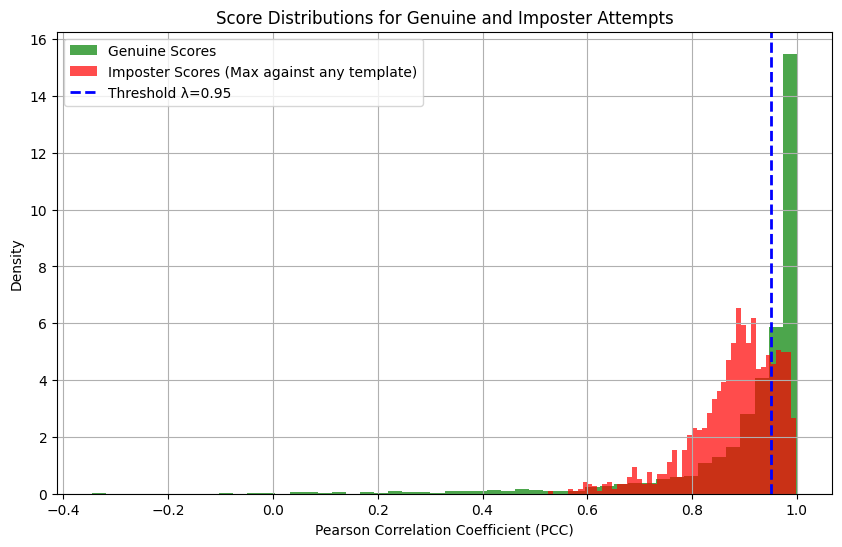

In [113]:

# Avoid division by zero if no FPs or no FNs etc.
FRR = false_negatives_FN / (true_positives_TP + false_negatives_FN) if (true_positives_TP + false_negatives_FN) > 0 else 0
FAR = false_positives_FP / (false_positives_FP + true_negatives_TN) if (false_positives_FP + true_negatives_TN) > 0 else 0

Accuracy = (true_positives_TP + true_negatives_TN) / (len(genuine_test_data) + len(imposter_test_data)) if (len(genuine_test_data) + len(imposter_test_data)) > 0 else 0

print("\n--- Authentication Performance Metrics ---")
print(f"Authentication Threshold (lambda): {AUTHENTICATION_THRESHOLD_LAMBDA}")
print(f"True Positives (TP): {true_positives_TP}")
print(f"False Negatives (FN) / Genuine Rejections: {false_negatives_FN}")
print(f"True Negatives (TN) / Imposter Rejections: {true_negatives_TN}")
print(f"False Positives (FP) / Imposter Acceptances: {false_positives_FP}")
print("------------------------------------------")
print(f"False Rejection Rate (FRR): {FRR:.4f} ({FRR*100:.2f}%)")
print(f"False Acceptance Rate (FAR): {FAR:.4f} ({FAR*100:.2f}%)")
print(f"Accuracy: {Accuracy:.4f} ({Accuracy*100:.2f}%)")

# --- Plotting Score Distributions (Optional but very insightful) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_genuine_scores, bins=50, alpha=0.7, label='Genuine Scores', color='green', density=True)
plt.hist(all_imposter_scores, bins=50, alpha=0.7, label='Imposter Scores (Max against any template)', color='red', density=True)
plt.axvline(AUTHENTICATION_THRESHOLD_LAMBDA, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold λ={AUTHENTICATION_THRESHOLD_LAMBDA}')
plt.title('Score Distributions for Genuine and Imposter Attempts')
plt.xlabel('Pearson Correlation Coefficient (PCC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


--- Authentication Performance Metrics ---
Authentication Threshold (lambda): 0.8
True Positives (TP): 2079
False Negatives (FN) / Genuine Rejections: 296
True Negatives (TN) / Imposter Rejections: 176
False Positives (FP) / Imposter Acceptances: 1054
------------------------------------------
False Rejection Rate (FRR): 0.1246 (12.46%)
False Acceptance Rate (FAR): 0.8569 (85.69%)
Accuracy: 0.6255 (62.55%)


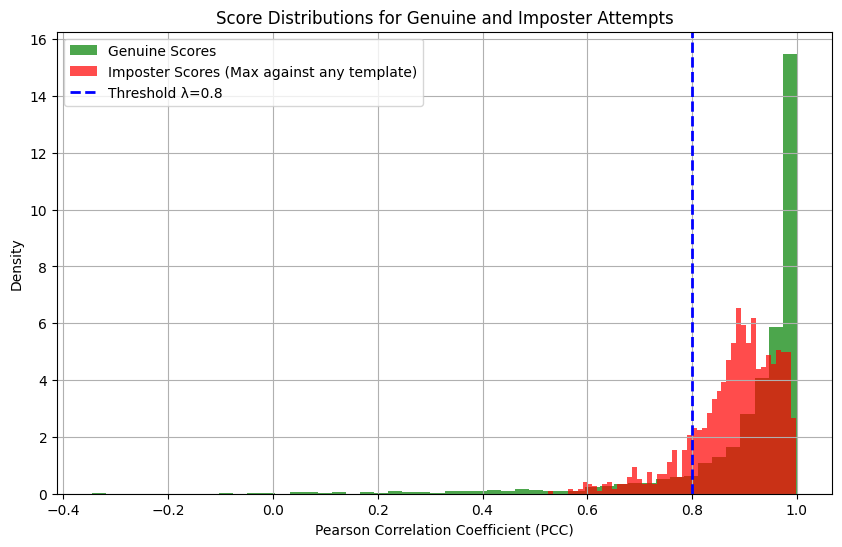

In [110]:


# --- Calculate Metrics ---
# Total genuine attempts = TP + FN = len(genuine_test_data)
# Total imposter segments tested = FP + TN = len(imposter_test_data)

# Avoid division by zero if no FPs or no FNs etc.
FRR = false_negatives_FN / (true_positives_TP + false_negatives_FN) if (true_positives_TP + false_negatives_FN) > 0 else 0
FAR = false_positives_FP / (false_positives_FP + true_negatives_TN) if (false_positives_FP + true_negatives_TN) > 0 else 0
# Alternative FAR if you consider each comparison of an imposter segment against a template as a trial:
# total_imposter_comparisons = len(imposter_test_data) * len(user_templates)
# FAR_per_comparison = false_positives_FP_per_comparison / total_imposter_comparisons 
# But the paper likely means FAR per imposter *attempt* (i.e., per imposter segment). Our current FAR is fine for that.


Accuracy = (true_positives_TP + true_negatives_TN) / (len(genuine_test_data) + len(imposter_test_data)) if (len(genuine_test_data) + len(imposter_test_data)) > 0 else 0

print("\n--- Authentication Performance Metrics ---")
print(f"Authentication Threshold (lambda): {AUTHENTICATION_THRESHOLD_LAMBDA}")
print(f"True Positives (TP): {true_positives_TP}")
print(f"False Negatives (FN) / Genuine Rejections: {false_negatives_FN}")
print(f"True Negatives (TN) / Imposter Rejections: {true_negatives_TN}")
print(f"False Positives (FP) / Imposter Acceptances: {false_positives_FP}")
print("------------------------------------------")
print(f"False Rejection Rate (FRR): {FRR:.4f} ({FRR*100:.2f}%)")
print(f"False Acceptance Rate (FAR): {FAR:.4f} ({FAR*100:.2f}%)")
print(f"Accuracy: {Accuracy:.4f} ({Accuracy*100:.2f}%)")

# --- Plotting Score Distributions (Optional but very insightful) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_genuine_scores, bins=50, alpha=0.7, label='Genuine Scores', color='green', density=True)
plt.hist(all_imposter_scores, bins=50, alpha=0.7, label='Imposter Scores (Max against any template)', color='red', density=True)
plt.axvline(AUTHENTICATION_THRESHOLD_LAMBDA, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold λ={AUTHENTICATION_THRESHOLD_LAMBDA}')
plt.title('Score Distributions for Genuine and Imposter Attempts')
plt.xlabel('Pearson Correlation Coefficient (PCC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


--- Authentication Performance Metrics ---
Authentication Threshold (lambda): 0.99
True Positives (TP): 234
False Negatives (FN) / Genuine Rejections: 1891
True Negatives (TN) / Imposter Rejections: 1230
False Positives (FP) / Imposter Acceptances: 0
------------------------------------------
False Rejection Rate (FRR): 0.8899 (88.99%)
False Acceptance Rate (FAR): 0.0000 (0.00%)
Accuracy: 0.4364 (43.64%)


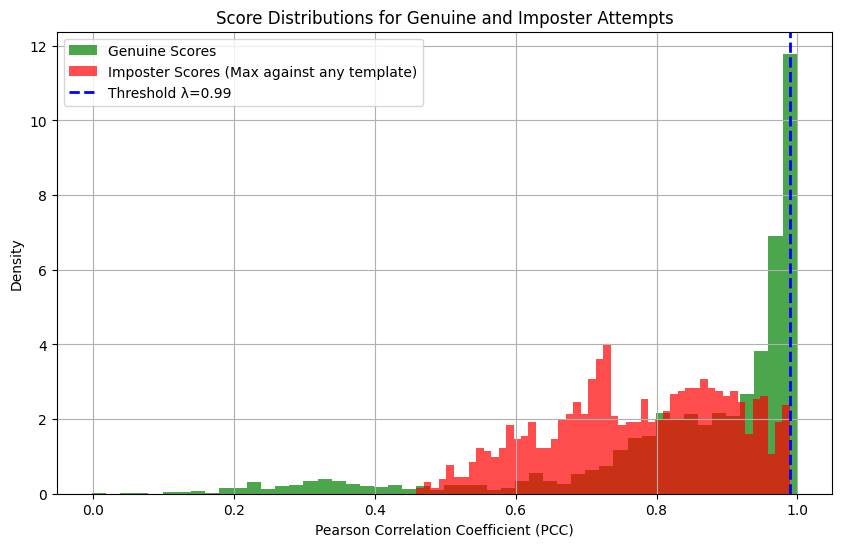

In [96]:


# --- Calculate Metrics ---
# Total genuine attempts = TP + FN = len(genuine_test_data)
# Total imposter segments tested = FP + TN = len(imposter_test_data)

# Avoid division by zero if no FPs or no FNs etc.
FRR = false_negatives_FN / (true_positives_TP + false_negatives_FN) if (true_positives_TP + false_negatives_FN) > 0 else 0
FAR = false_positives_FP / (false_positives_FP + true_negatives_TN) if (false_positives_FP + true_negatives_TN) > 0 else 0
# Alternative FAR if you consider each comparison of an imposter segment against a template as a trial:
# total_imposter_comparisons = len(imposter_test_data) * len(user_templates)
# FAR_per_comparison = false_positives_FP_per_comparison / total_imposter_comparisons 
# But the paper likely means FAR per imposter *attempt* (i.e., per imposter segment). Our current FAR is fine for that.


Accuracy = (true_positives_TP + true_negatives_TN) / (len(genuine_test_data) + len(imposter_test_data)) if (len(genuine_test_data) + len(imposter_test_data)) > 0 else 0

print("\n--- Authentication Performance Metrics ---")
print(f"Authentication Threshold (lambda): {AUTHENTICATION_THRESHOLD_LAMBDA}")
print(f"True Positives (TP): {true_positives_TP}")
print(f"False Negatives (FN) / Genuine Rejections: {false_negatives_FN}")
print(f"True Negatives (TN) / Imposter Rejections: {true_negatives_TN}")
print(f"False Positives (FP) / Imposter Acceptances: {false_positives_FP}")
print("------------------------------------------")
print(f"False Rejection Rate (FRR): {FRR:.4f} ({FRR*100:.2f}%)")
print(f"False Acceptance Rate (FAR): {FAR:.4f} ({FAR*100:.2f}%)")
print(f"Accuracy: {Accuracy:.4f} ({Accuracy*100:.2f}%)")

# --- Plotting Score Distributions (Optional but very insightful) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_genuine_scores, bins=50, alpha=0.7, label='Genuine Scores', color='green', density=True)
plt.hist(all_imposter_scores, bins=50, alpha=0.7, label='Imposter Scores (Max against any template)', color='red', density=True)
plt.axvline(AUTHENTICATION_THRESHOLD_LAMBDA, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold λ={AUTHENTICATION_THRESHOLD_LAMBDA}')
plt.title('Score Distributions for Genuine and Imposter Attempts')
plt.xlabel('Pearson Correlation Coefficient (PCC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


--- Authentication Performance Metrics ---
Authentication Threshold (lambda): 0.6
True Positives (TP): 1921
False Negatives (FN) / Genuine Rejections: 204
True Negatives (TN) / Imposter Rejections: 134
False Positives (FP) / Imposter Acceptances: 1096
------------------------------------------
False Rejection Rate (FRR): 0.0960 (9.60%)
False Acceptance Rate (FAR): 0.8911 (89.11%)
Accuracy: 0.6125 (61.25%)


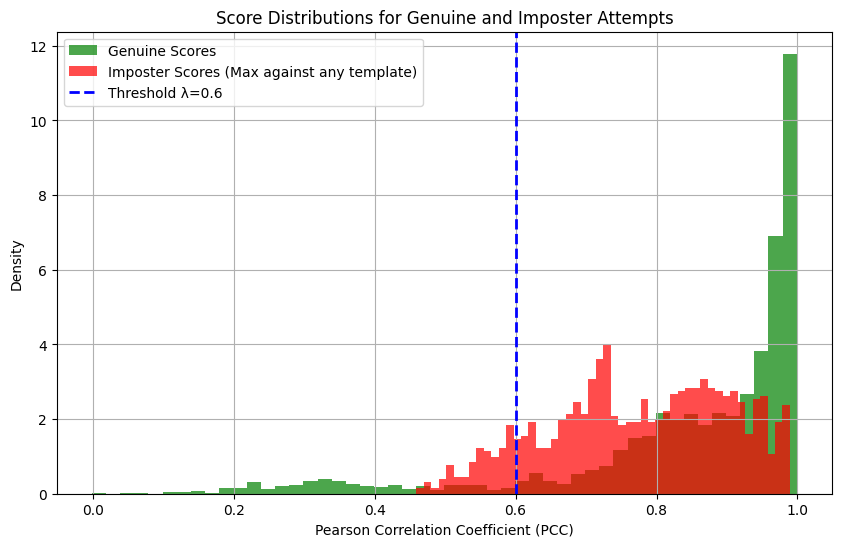

In [93]:


# --- Calculate Metrics ---
# Total genuine attempts = TP + FN = len(genuine_test_data)
# Total imposter segments tested = FP + TN = len(imposter_test_data)

# Avoid division by zero if no FPs or no FNs etc.
FRR = false_negatives_FN / (true_positives_TP + false_negatives_FN) if (true_positives_TP + false_negatives_FN) > 0 else 0
FAR = false_positives_FP / (false_positives_FP + true_negatives_TN) if (false_positives_FP + true_negatives_TN) > 0 else 0
# Alternative FAR if you consider each comparison of an imposter segment against a template as a trial:
# total_imposter_comparisons = len(imposter_test_data) * len(user_templates)
# FAR_per_comparison = false_positives_FP_per_comparison / total_imposter_comparisons 
# But the paper likely means FAR per imposter *attempt* (i.e., per imposter segment). Our current FAR is fine for that.


Accuracy = (true_positives_TP + true_negatives_TN) / (len(genuine_test_data) + len(imposter_test_data)) if (len(genuine_test_data) + len(imposter_test_data)) > 0 else 0

print("\n--- Authentication Performance Metrics ---")
print(f"Authentication Threshold (lambda): {AUTHENTICATION_THRESHOLD_LAMBDA}")
print(f"True Positives (TP): {true_positives_TP}")
print(f"False Negatives (FN) / Genuine Rejections: {false_negatives_FN}")
print(f"True Negatives (TN) / Imposter Rejections: {true_negatives_TN}")
print(f"False Positives (FP) / Imposter Acceptances: {false_positives_FP}")
print("------------------------------------------")
print(f"False Rejection Rate (FRR): {FRR:.4f} ({FRR*100:.2f}%)")
print(f"False Acceptance Rate (FAR): {FAR:.4f} ({FAR*100:.2f}%)")
print(f"Accuracy: {Accuracy:.4f} ({Accuracy*100:.2f}%)")

# --- Plotting Score Distributions (Optional but very insightful) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_genuine_scores, bins=50, alpha=0.7, label='Genuine Scores', color='green', density=True)
plt.hist(all_imposter_scores, bins=50, alpha=0.7, label='Imposter Scores (Max against any template)', color='red', density=True)
plt.axvline(AUTHENTICATION_THRESHOLD_LAMBDA, color='blue', linestyle='dashed', linewidth=2, label=f'Threshold λ={AUTHENTICATION_THRESHOLD_LAMBDA}')
plt.title('Score Distributions for Genuine and Imposter Attempts')
plt.xlabel('Pearson Correlation Coefficient (PCC)')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()